This notebook will explore the use of Restricted Boltzmann Machines in a Collaborative Filtering based recommendation system. 
<br>
<br>
This model will recommend items by tring to find users that are similar to each other based on their item ratings
<br>
<br>
<h3> Downloading Data </h3>
These datasets were aquired by <a href="http://grouplens.org/datasets/movielens/">GroupLens</a> and contain movies, users, and movie ratings by these users

In [3]:
!wget -O ./data/moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o ./data/moviedataset.zip -d ./data

--2019-03-11 15:18:45--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./data/moviedataset.zip’

./data/moviedataset 100%[=====================>]   5.64M  12.7MB/s   in 0.4s   

2019-03-11 15:18:47 (12.7 MB/s) - ‘./data/moviedataset.zip’ saved [5917549/5917549]

Archive:  ./data/moviedataset.zip
  inflating: ./data/ml-1m/movies.dat  
  inflating: ./data/ml-1m/ratings.dat  
  inflating: ./data/ml-1m/README     
  inflating: ./data/ml-1m/users.dat  


In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<h3> Loading Data </h3>

In [5]:
#Loading in the movies dataset -- instead of being separated by commas like csv's,
# this dataset is separated by ::
movies_df = pd.read_csv('./data/ml-1m/movies.dat', sep='::', header=None, engine='python')
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# Loading the ratings dataset
ratings_df = pd.read_csv('./data/ml-1m/ratings.dat', sep='::', header=None, engine='python')
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


<h3> RBM Model Overview </h3>
<br>
<img src="http://i1380.photobucket.com/albums/ah175/nickwalker037/films_zpshc4dkk4a.png~original"  width="300"> 
<br>
<i> Source: IBM </i>
<br>

- The input layer in our model will contain X neurons, where X is the number of movies in our dataset
- These neurons will pass a normalized value (between 0 and 1) representing whether has watched the movie or not
- After passing the input layer, we train the hidden layer in the RBM to learn the appropriate features

<br>
<h3> Normalizing the Ratings </h3>

In [7]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<h3> Setting the Model Parameters </h3>
Creating placeholders for the biases and weights:

In [9]:
hiddenUnits = 20
visibleUnits = len(user_rating_df.columns)
visible_bias = tf.placeholder("float", [visibleUnits]) # number of visible units
hidden_bias = tf.placeholder("float", [hiddenUnits]) # number of hidden units
W = tf.placeholder("float", [visibleUnits, hiddenUnits]) # weights

Creating the visible and hidden layer units and setting their activation functions:

In [10]:
# Input Processing:
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hidden_bias)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

In [11]:
# Reconstruction:
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W) + visible_bias))
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hidden_bias)

Setting the training parameters and functions:

In [12]:
# Learning Rate:
alpha = 0.1

# Gradients:
w_pos_gradient = tf.matmul(tf.transpose(v0), h0)
w_neg_gradient = tf.matmul(tf.transpose(v1), h1)

# Create the contrastive divergence to maximize:
CD = (w_pos_gradient - w_neg_gradient) / tf.to_float(tf.shape(v0)[0])

# Create methods to update the weights and biases:
update_w = W + alpha * CD
update_vb = visible_bias + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hidden_bias + alpha * tf.reduce_mean(h0 - h1, 0)

Set the error function to the Mean Absolute Error Function:

In [13]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

<h3> Initializing Variables </h3>
We'll use the <code>zeros</code> numpy function for this

In [33]:
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32) # current weight
cur_vb = np.zeros([visibleUnits], np.float32) # current visible unit bias
cur_hb = np.zeros([hiddenUnits], np.float32) # current hidden unit bias

prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32) # previous weight
prv_vb = np.zeros([visibleUnits], np.float32) # previous visible unit bias
prv_hb = np.zeros([hiddenUnits], np.float32) # previous hidden unit bias

sess = tf.Session()
sess.run(tf.global_variables_initializer())

---------------------------------------------------------------------------------
<h3> Training the Model </h3

Error in epoch 0 is:  0.051670384
Error in epoch 1 is:  0.05725536
Error in epoch 2 is:  0.059951484
Error in epoch 3 is:  0.062402062
Error in epoch 4 is:  0.063720725
Error in epoch 5 is:  0.0607368
Error in epoch 6 is:  0.059822157
Error in epoch 7 is:  0.05932057
Error in epoch 8 is:  0.05742299
Error in epoch 9 is:  0.056101523
Error in epoch 10 is:  0.055622328
Error in epoch 11 is:  0.054199494
Error in epoch 12 is:  0.054116614
Error in epoch 13 is:  0.05284954
Error in epoch 14 is:  0.052299697


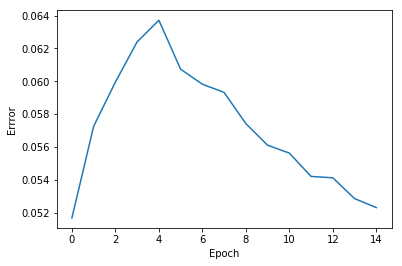

In [34]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip(range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict = {v0: batch, W: prv_w, visible_bias: prv_vb, hidden_bias: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict = {v0: batch, W: prv_w, visible_bias: prv_vb, hidden_bias: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict = {v0: batch, W: prv_w, visible_bias: prv_vb, hidden_bias: prv_hb})
        
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict = {v0: trX, W: cur_w, visible_bias: cur_vb, hidden_bias: cur_hb}))
    print("Error in epoch", i, "is: ", errors[-1])
plt.plot(errors)
plt.ylabel('Errror')
plt.xlabel('Epoch')
plt.show()

<h3> Recommendation </h3>
Here we will predict movies that an arbitrary user might like. We'll feed the user's watched movie preferences into our RBM and then reconstruct the input

In [55]:
# choosing a random user:
mock_user_id = 1200

In [56]:
# selecting user input:
inputUser = trX[mock_user_id - 1].reshape(1, -1)
inputUser

array([[0., 0., 0., ..., 0., 0., 0.]])

In [57]:
# feeding in the user and reconstructing the input:
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hidden_bias)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + visible_bias)
feed = sess.run(hh0, feed_dict = {v0: inputUser, W: prv_w, hidden_bias: prv_hb})
rec = sess.run(vv1, feed_dict = {hh0: feed, W: prv_w, visible_bias: prv_vb})
print(rec)

[[0.38593033 0.17380296 0.28232712 ... 0.16622783 0.16698916 0.48932716]]


We can then find the top 10 most recommended movies by sorting it by their scores given in our model:

In [58]:
scored_movies_df_mock = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0])
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(10)

,MovieID,Title,Genres,RecommendationScore
2789,2858,American Beauty (1999),Comedy|Drama,0.999991
2693,2762,"Sixth Sense, The (1999)",Thriller,0.970101
2928,2997,Being John Malkovich (1999),Comedy,0.939022
3339,3408,Erin Brockovich (2000),Drama,0.936107
3509,3578,Gladiator (2000),Action|Drama,0.924160
3684,3753,"Patriot, The (2000)",Action|Drama|War,0.906455
2890,2959,Fight Club (1999),Drama,0.905141
3554,3623,Mission: Impossible 2 (2000),Action|Thriller,0.876660
2637,2706,American Pie (1999),Comedy,0.870925
3091,3160,Magnolia (1999),Drama,0.856521


Finding all the movies our mock user has watched before and looking at 20 of the highest rated movies:

In [59]:
movies_df_mock = ratings_df[ratings_df['UserID'] == mock_user_id]
watched_movies_df_mock = movies_df_mock.merge(movies_df, on='MovieID', how='inner')
watched_movies_df_mock.sort_values(["Rating"], ascending=False).head(20)

,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1200,1249,5,974846432,Nikita (La Femme Nikita) (1990),Thriller
13,1200,2686,5,974854828,"Red Violin, The (Le Violon rouge) (1998)",Drama|Mystery
34,1200,2762,5,974855603,"Sixth Sense, The (1999)",Thriller
31,1200,2712,5,974852632,Eyes Wide Shut (1999),Drama
27,1200,3354,5,974853850,Mission to Mars (2000),Sci-Fi
26,1200,2541,5,974850184,Cruel Intentions (1999),Drama
16,1200,2841,5,974855603,Stir of Echoes (1999),Thriller
15,1200,2840,5,974855603,Stigmata (1999),Thriller
38,1200,1093,5,974850425,"Doors, The (1991)",Drama|Musical
6,1200,2600,5,974855654,eXistenZ (1999),Action|Sci-Fi|Thriller


Merging the watched movies with the recommended movies to see if there's overlap:
- If there is overlap, it means we're recommending movies that the user hopefully already liked, and is a good sign our model is performing well. We would recommend the movies from this list in which there is no overlap

In [60]:
merged_df_mock = scored_movies_df_mock.merge(movies_df_mock, on='MovieID', how='outer')

In [61]:
merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore,UserID,Rating,Timestamp
2651,2858,American Beauty (1999),Comedy|Drama,0.999991,1200.0,3.0,974847840.0
2557,2762,"Sixth Sense, The (1999)",Thriller,0.970101,1200.0,5.0,974855603.0
2785,2997,Being John Malkovich (1999),Comedy,0.939022,1200.0,3.0,974856822.0
3177,3408,Erin Brockovich (2000),Drama,0.936107,NaN,NaN,NaN
3341,3578,Gladiator (2000),Action|Drama,0.924160,NaN,NaN,NaN
3510,3753,"Patriot, The (2000)",Action|Drama|War,0.906455,1200.0,3.0,974853883.0
2748,2959,Fight Club (1999),Drama,0.905141,NaN,NaN,NaN
3383,3623,Mission: Impossible 2 (2000),Action|Thriller,0.876660,NaN,NaN,NaN
2501,2706,American Pie (1999),Comedy,0.870925,1200.0,3.0,974847840.0
2944,3160,Magnolia (1999),Drama,0.856521,NaN,NaN,NaN
